In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
path='/content/next word.txt'
text=open(path).read().lower()
print('size of text:',len(text))

size of text: 581888


In [4]:
tokenizer=RegexpTokenizer(r"\w+")
words=tokenizer.tokenize(text)

In [5]:
unique_words = np.unique(words)

In [6]:
unique_word_index ={}
for index,word in enumerate(unique_words):
  unique_word_index[word]=index

In [7]:
word_len = 5
prev_words = []
next_words = []

In [8]:
for i in range(len(words)-word_len):
  prev_words.append(words[i:i+word_len])
  next_words.append(words[i+word_len])
print(prev_words[1])
print(next_words[1])

['gutenberg', 's', 'the', 'adventures', 'of']
sherlock


In [9]:
X = np.zeros((len(prev_words), word_len, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [10]:
print(X[0][0])

[False False False ... False False False]


In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(word_len, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [12]:
optimizer = RMSprop(learning_rate=0.01) # Use learning_rate instead of lr
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=30, shuffle=True).history

Epoch 1/30
811/811 [==============================] - 36s 42ms/step - loss: 6.3420 - accuracy: 0.0710 - val_loss: 7.1061 - val_accuracy: 0.0806
Epoch 2/30
811/811 [==============================] - 33s 41ms/step - loss: 5.8028 - accuracy: 0.1109 - val_loss: 6.7783 - val_accuracy: 0.0934
Epoch 3/30
811/811 [==============================] - 33s 41ms/step - loss: 5.5045 - accuracy: 0.1331 - val_loss: 6.6514 - val_accuracy: 0.1029
Epoch 4/30
811/811 [==============================] - 33s 41ms/step - loss: 5.2543 - accuracy: 0.1520 - val_loss: 6.6429 - val_accuracy: 0.0987
Epoch 5/30
811/811 [==============================] - 34s 42ms/step - loss: 5.0224 - accuracy: 0.1700 - val_loss: 6.7005 - val_accuracy: 0.1031
Epoch 6/30
811/811 [==============================] - 34s 41ms/step - loss: 4.7792 - accuracy: 0.1936 - val_loss: 6.6886 - val_accuracy: 0.0981
Epoch 7/30
811/811 [==============================] - 33s 41ms/step - loss: 4.5115 - accuracy: 0.2233 - val_loss: 6.7470 - val_accuracy:

In [13]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


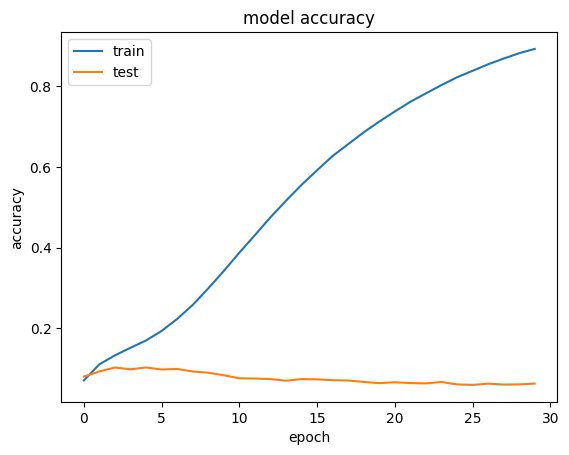

In [14]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


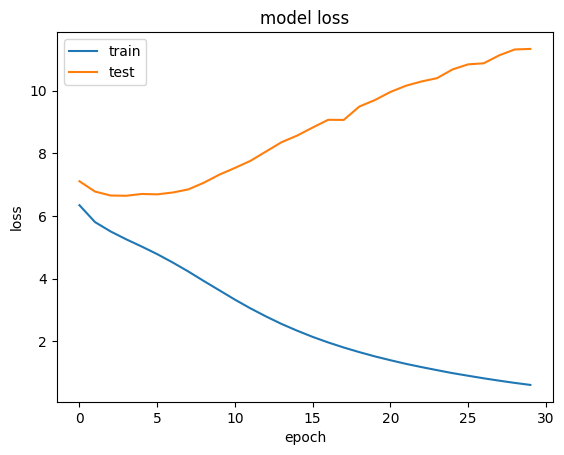

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [16]:
def prepare_input(text):
    x = np.zeros((1, word_len, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)

In [17]:
prepare_input("This is an example of input for our LSTM".lower())

this
is
an
example
of
input
for
our
lstm


In [18]:
def prepare_input(text, sequence_length=5):
    x = np.zeros((1, sequence_length, len(unique_words)))
    words = text.split()
    for t, word in enumerate(words[-sequence_length:]):
        if word in unique_word_index:
            x[0, t, unique_word_index[word]] = 1.0
    return x

In [19]:
prepare_input("It is not a lack".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [20]:
def sample(preds, n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(preds)
    preds = preds / np.sum(preds)  # Normalizing
    return np.random.choice(len(preds), n, p=preds)

In [21]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    next_words = [unique_words[idx] for idx in next_indices]
    return next_words


In [22]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    next_words = [unique_words[idx] for idx in next_indices]
    return next_words

In [23]:
inuput = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [26]:
for sentence in inuput:
    seq = sentence.lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of friendship that makes unhappy marriages.
['finder', 'afford', 'distinct', 'printed', 'required']

that which does not kill us makes us stronger.
['terminated', 'glowing', 'consuming', 'hers', 'comes']

i'm not upset that you lied to me, i'm upset that from now on i can't believe you.
['detailed', 'herself', 'college', 'campaigner', 'fenchurch']

and those who were seen dancing were thought to be insane by those who could not hear the music.
['unmarried', 'steam', 'neutral', 'leader', 'lapse']

it is hard enough to remember my opinions, without also remembering my reasons for them!
['trepoff', 'snarled', 'effect', 'advertise', 'abuse']

